In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input
from tensorflow.keras import Model
from tensorflow import keras
import sys
sys.path.append("..")   # add parent directory to Python path
import functions
from pathlib import Path
from reservoirpy.nodes import Reservoir, Ridge

In [24]:
class autoEncoder:
    def __init__(self, sequence_length, first_layer_dim = 128, second_layer_dim = 32):
        self.sequence_length = sequence_length
        self.first_layer_dim = first_layer_dim
        self.second_layer_dim = second_layer_dim
        self.model = self.build_model()
        self.X_train,self.X_test, self.Y_train, self.Y_test = self.get_data()
        self.model_is_fitted = False
    def build_model(self):
        self.model = Sequential()

        # Encoder part
        self.model.add(LSTM(self.first_layer_dim, return_sequences=True, input_shape=(self.sequence_length, 1)))
        self.model.add(LSTM(self.second_layer_dim, return_sequences=True))

        # Decoder part  
        self.model.add(LSTM(self.first_layer_dim, return_sequences=True))
        self.model.add(TimeDistributed(Dense(1)))  # Output (batch, time, 1), TimeDistributed helps to handle all dim after second ones
        
        self.model.summary()
        self.model.compile(optimizer='adam', loss='mse')
        return self.model

    def get_data(self, test_size=0.2):
        data_lst = []
        scaler = MinMaxScaler(feature_range=(0,1))
        folder = Path("D:\Documents\GitHub\ML_cardiac_prediction\data")
        for p in folder.glob("*.csv"):   # use rglob("*.csv") for subfolders
            voltage = functions.load_voltage(p)
            if len(voltage) <= self.sequence_length:
                continue
            scaled_voltage = scaler.fit_transform(voltage.reshape(-1, 1))
            data_lst.append(scaled_voltage)
        X = []
        Y = []
        for scaled_voltage in data_lst:
            X.append(scaled_voltage[0:self.sequence_length, 0])
            Y.append(scaled_voltage[1:self.sequence_length + 1, 0])
        X = np.array(X)
        Y = np.array(Y)
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size,  shuffle=False)

        X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
        X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
        return X_train, X_test , Y_train, Y_test
    
    def train(self, epochs=30, batch_size=1,save_model=True):
        history = self.model.fit(self.X_train, self.X_train,
                                validation_data=(self.X_test, self.X_test),
                                epochs=epochs, 
                                batch_size=batch_size)
        self.model_is_fitted = True   
        print(self.test())
        if save_model:
            self.model.save(f"AE_seql_{self.sequence_length}_firstL_{self.first_layer_dim}_secondL_{self.second_layer_dim}_epochs_{epochs}.keras")
            
        encoder, decoder = self.get_encoder_decoder()
        return encoder, decoder, history
    def get_encoder_decoder(self):
        if not self.model_is_fitted:
            raise ValueError("Model is not fitted or loaded. Please build or load a model first.")
        encoder = Model(inputs=self.model.layers[0].input,
                        outputs=self.model.layers[1].output)
        # Decoder (create independent input)
        
        latent_input = tf.keras.Input(shape=(self.sequence_length, self.second_layer_dim))
        x = self.model.layers[2](latent_input)
        
        decoder_output = self.model.layers[3](x)
        decoder = Model(inputs=latent_input, outputs=decoder_output)
        return encoder, decoder
    
    def load_model(self, model_path="AE_seql_4500_firstL_128_secondL_32_epochs_60.keras"):
        self.model = keras.models.load_model(model_path)
        self.model_is_fitted = True
        self.first_layer_dim = self.model.layers[0].units
        self.second_layer_dim = self.model.layers[1].units
        self.sequence_length = self.model.input_shape[1]
        return self.model
    
    def test(self):
        if not self.model_is_fitted:
            raise ValueError("Model is not fitted or loaded. Please build or load a model first.")
        X_test_pred = self.model.predict(self.X_test)
        rmse = np.sqrt(mean_squared_error(self.X_test.flatten(), X_test_pred.flatten()))
        print(f"Test Loss: {rmse}")
        return rmse
    
    
    

<>:27: SyntaxWarning: invalid escape sequence '\D'
<>:27: SyntaxWarning: invalid escape sequence '\D'
C:\Users\11061\AppData\Local\Temp\ipykernel_11900\791444497.py:27: SyntaxWarning: invalid escape sequence '\D'
  folder = Path("D:\Documents\GitHub\ML_cardiac_prediction\data")


In [3]:
model = autoEncoder(5000)

d:\Anaconda\envs\lstm\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5000, 128)      │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 5000, 32)       │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 5000, 128)      │        82,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed                │ (None, 5000, 1)        │           129 │
│ (TimeDistributed)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 169,729 (663.00 KB)

 Trainable params: 169,729 (663.00 KB)

 Non-trainable params: 0 (0.00 B)

In [6]:
model.train(epochs=30, batch_size=1)

Epoch 1/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 98s 6s/step - loss: 0.0358 - val_loss: 0.0328
Epoch 2/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 0.0298 - val_loss: 0.0274
Epoch 3/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - loss: 0.0250 - val_loss: 0.0231
Epoch 4/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 0.0212 - val_loss: 0.0194
Epoch 5/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 97s 6s/step - loss: 0.0183 - val_loss: 0.0167
Epoch 6/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step - loss: 0.0160 - val_loss: 0.0143
Epoch 7/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 97s 6s/step - loss: 0.0133 - val_loss: 0.0112
Epoch 8/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 99s 6s/step - loss: 0.0176 - val_loss: 0.0169
Epoch 9/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 0.0127 - val_loss: 0.0110
Epoch 10/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 0.0105 - val_loss: 0.0096
Epoch 11/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 0.0091 - val_loss: 0.0081
Epoch 12/30
16/16 ━━━━━━━━━━━━━━━━━━━━ 96s 6s/step - loss: 0.0078 - val_l

(<Functional name=functional_8, built=True>,
 <Functional name=functional_9, built=True>,
 <keras.src.callbacks.history.History at 0x282d93f7b10>)

In [26]:
encoder,decoder = model.get_encoder_decoder()

In [33]:
scaler = MinMaxScaler(feature_range=(0,1))
voltage = functions.load_voltage(r"D:\Documents\GitHub\ML_cardiac_prediction\data\tau_d_0.41_temporal_APD_step_4 (2).csv")
scaled_voltage = scaler.fit_transform(voltage.reshape(-1, 1))

In [34]:
scaled_voltage  = np.expand_dims(scaled_voltage, axis=0)
print(scaled_voltage.shape)

(1, 25000, 1)


In [35]:
latent_scaled_voltage = encoder.predict(scaled_voltage)
latent_back_scaled_voltage = decoder.predict(latent_scaled_voltage)
print(np.sqrt(mean_squared_error(scaled_voltage.flatten(), latent_back_scaled_voltage.flatten())))

ValueError: Input 0 of layer "functional_10" is incompatible with the layer: expected shape=(None, 5000, 1), found shape=(1, 25000)

In [ ]:
latent_X_train = encoder.predict(model.X_train[:,:,:])
latent_X_train.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(16, 5000, 32)

In [21]:
model.X_train.shape

(16, 5000, 1)

In [17]:
latent_Y_train = encoder.predict(model.Y_train[:,:,:])
latent_Y_train.shape

IndexError: too many indices for array: array is 2-dimensional, but 3 were indexed

In [13]:

# ---- Give your data sizes names you can fill in ----
N_IN  = 1   # number of input features  (you set this)
N_OUT = 32   # number of output targets (you set this)

# ---- Hyperparameters: defaults chosen from the bold values in your table ----
nr        = 500     # units (n_r)
sigma_in  = 0.10    # input_scaling (σ_in)
rho       = 1.15    # sr (spectral radius)
alpha     = 0.90    # lr (leaking rate)
lam       = 1e-3    # ridge regularization (λ)
pr        = 0.2    # connection probability for recurrent matrix (p_r)
pin       = 0.10    # (optional) input connectivity; set if you want to control Win sparsity

reservoir = Reservoir(
    units=nr,
    lr=alpha,
    sr=rho,
    input_scaling=sigma_in,
    rc_connectivity=pr,        # recurrent sparsity (your p_r)
    input_connectivity=pin,    # input sparsity (optional)
    seed=29,
    
)

readout = Ridge(ridge=lam, input_dim=nr, output_dim=N_OUT)

esn = reservoir >> readout
# Shapes you should provide:
# X: (T, N_IN)    Y: (T, N_OUT)
# esn = esn.fit(X, Y)
# Yhat = esn.run(X)


In [22]:
esn = esn.fit(latent_X_train[0],latent_Y_train[0])

In [ ]:
Y_pred = []
x = latent_X_train[0,4500-1,:]
print(x.shape)
for _ in range(4500):
    x = esn(x)
    Y_pred.append(x)


(32,)


In [29]:
np.array(Y_pred).shape

(4500, 32)

In [ ]:
x = decoder.predict(np.expand_dims(Y_pred, axis=0))
x.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 20s 20s/step


(1, 4500, 1)

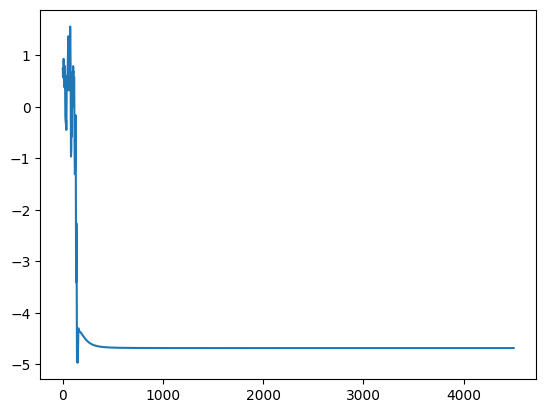

In [35]:
plt.plot(x[0])
plt.plot(X_train[0][4500:9000])

In [253]:
X_test_latent = encoder.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 450ms/step


In [256]:
Y_pred = esn.run(X_test_latent[-1,:900,:])
result = decoder.predict(np.expand_dims(Y_pred, axis=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


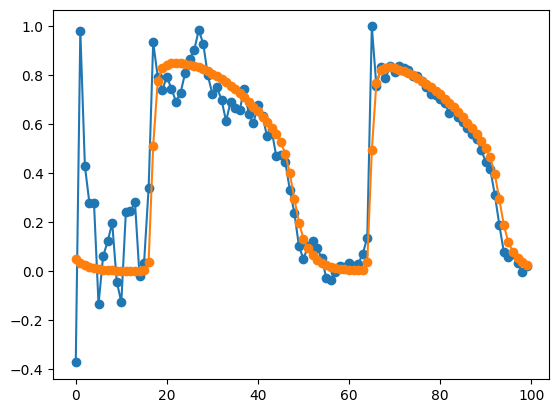

In [261]:
plt.plot(result[0][:100],'-o')
plt.plot(X_test[-1][:100],'-o')